In [ ]:
import numpy as np
import math
import sys
import progressbar
import matplotlib.pyplot as plt

In [ ]:
def to_categorical(x, n_col=None):
    """ One-hot encoding номинального признака """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot
def divide_on_feature(X, feature_i, threshold):
    """ Разделение набора данных по превышению признака feature_i порога"""
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])
    return X_1, X_2


def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def shuffle_data(X, y, seed=None):
    """ случайное перемешивание X и y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Разделение набора данных на обучающий и тестовый """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def to_nominal(x):
    """ Перевод из one-hot encoding в номинальные значения """
    return np.argmax(x, axis=1)

def calculate_entropy(y):
    """ энтропия """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def calculate_variance(X):
    """ дисперсия X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))

    return variance


def mean_squared_error(y_true, y_pred):
    """ средняя квадратичная ошибка (y_true, y_pred) """
    mse = (np.power(y_true - y_pred, 2)).mean()
    return mse

def accuracy_score(y_true, y_pred):
    """ Доля правильных ответов """
    accuracy = np.mean(y_true == y_pred, axis=0)
    return accuracy

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)

bar_widgets = [
    'Обучение: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

In [ ]:
class DecisionNode():
    """Узел или лист дерева

    Параметры:
    -----------
    feature_i: int
        Номер признака, используемого для ветвления.
    threshold: float
        Пороговое значение, с которым мы будем сравнивать значения признака feature_i при определении прогноза.
    value: float
        Предсказанный класс для задачи классификации или предсказанное значение числового признака y для задачи регрессии.
    true_branch: DecisionNode
        Следующий узел в случае превышения порога.
    false_branch: DecisionNode
        Следующий узел в случае недостижения порога.
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i
        self.threshold = threshold
        self.value = value
        self.true_branch = true_branch
        self.false_branch = false_branch

In [ ]:
class DecisionTree(object):
    """Родительский класс для RegressionTree и ClassificationTree.

    Параметры:
    -----------
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потерь, используемая в градиентном бустинге для вычисления информативности.
    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Корневой узел

        self.min_samples_split = min_samples_split

        self.min_impurity = min_impurity

        self.max_depth = max_depth

        self._impurity_calculation = None

        self._leaf_value_calculation = None

        self.one_dim = None

        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Построение дерева """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Рекурсивный метод, который строит дерево решений и разбивает X и соответствующий y
        по признаку, который (на основе информативности) наилучшим образом разделяет данные"""

        largest_impurity = 0
        best_criteria = None    # номер факторного признака и порог
        best_sets = None        # Подмножества данных

        #
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        #
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Вычисляем информативность для каждого факторного признака
            for feature_i in range(n_features):
                # ВСЕ значения признака feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Цикл по всем уникальным значениям feature_i с вычислением информативности
                for threshold in unique_values:
                    # Разделение X и y по критерию X[feature_i] >= threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Значения y-в двух подмножествах
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Вычисление информативности
                        impurity = self._impurity_calculation(y, y1, y2)

                        # Если порог привел к повышению информационного выигрыша,
                        # сохраним порогт и номер признака
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X левого поддерева
                                "lefty": Xy1[:, n_features:],   # y левого поддерева
                                "rightX": Xy2[:, :n_features],  # X правого поддерева
                                "righty": Xy2[:, n_features:]   # y правого поддерева
                                }

        if largest_impurity > self.min_impurity:
            # Строим поддеревья
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # Определение значения в листе
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Рекурсивный поиск вниз по дереву с построением прогноза по значению итогового листа"""

        if tree is None:
            tree = self.root

        # Если мы находимся в листе, т.е. есть значение value, возвращаем его как прогноз
        if tree.value is not None:
            return tree.value

        # Выбор факторного признака
        feature_value = x[tree.feature_i]

        # Выбор левого или правого поддерева в зависимости от превышения порога
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Прогноз на поддереве
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Поэлементная классификация набора данных с возвращением множества прогнозов y"""
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Рекурсивный вывод дерева """
        if not tree:
            tree = self.root

        # Если это лист, выводим значение
        if tree.value is not None:
            print (tree.value)
        # иначе идем вглубь
        else:
            # номер признака и порог
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Сценарий при достижении порога
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Сценарий при недостижении порога
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)

In [ ]:
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Вычисление уменьшения дисперсии
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Вычисление информационного выигрыша
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Вычисление размера мажоритарного класса
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)


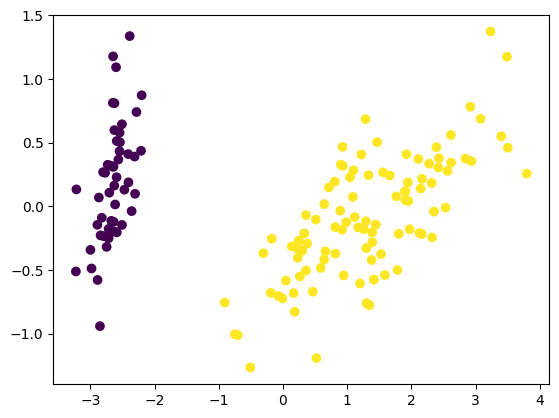

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

In [ ]:
dt = ClassificationTree(min_samples_split=1, min_impurity=1e-7, max_depth=2)
dt.fit(X_train, y_train)

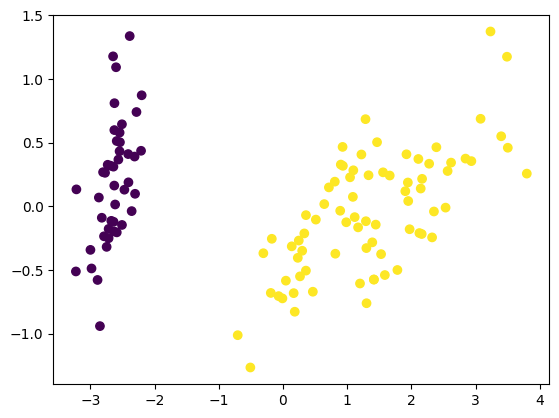

In [ ]:
y_pred = dt.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

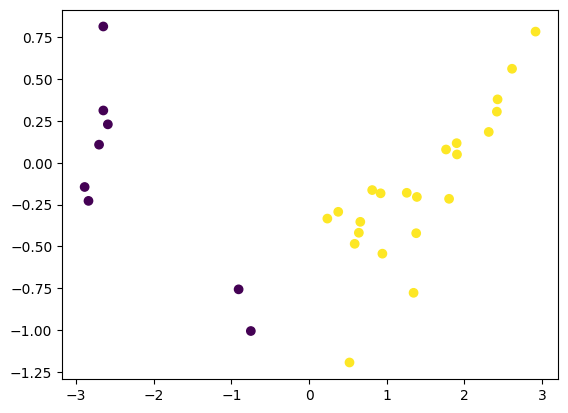

In [ ]:
y_pred = dt.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
dt.print_tree()

0:-0.7045317592446643? 
 T->1.0
 F->0.0


In [ ]:
class GradientBoosting(object):
    """Родительский класс для GradientBoostingClassifier и GradientBoostinRegressor.
    Использует набор деревьев для обучения предсказанию градиента функции потерь.

    Параметры:
    -----------
    n_estimators: int
        Число деревьев.
    learning_rate: float
        Скорость обучения - длина шага в направлении антиградиента
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потерь, используемая в градиентном бустинге для вычисления информативности.
    regression: boolean
        Регрессия или классификация.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.bar = progressbar.ProgressBar(widgets=bar_widgets)

        # Средняя квадратичная ошибка для регрессии, кросс-энтропия для классификации
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        # Инициализация
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):

        for i in self.bar(range(self.n_estimators)):
            if i == 0:
                self.trees[0].fit(X, y)
                y_pred = np.array(self.trees[0].predict(X))
                continue
            gradient = self.loss.gradient(y, y_pred)
            gradient *= -1 * self.learning_rate
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            # Обновление прогноза y
            y_pred += update


    def predict(self, X):
        y_pred = np.array([])
        # Вычисление прогнозов
        for tree in self.trees:
            update = np.array(tree.predict(X))
            y_pred = update if not len(y_pred) else y_pred + update

        if not self.regression:
            # переход к распределению вероятностей
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Прогноз - значение с максимальной вероятностью
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred


class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            min_impurity=min_var_red,
            max_depth=max_depth,
            regression=True)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

Обучение: 100% [-----------------------------------------------] Time:  0:00:34


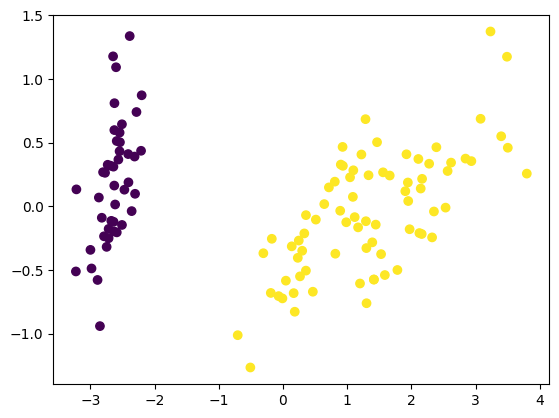

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.5, min_samples_split=1, min_info_gain=1e-7, max_depth=4, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

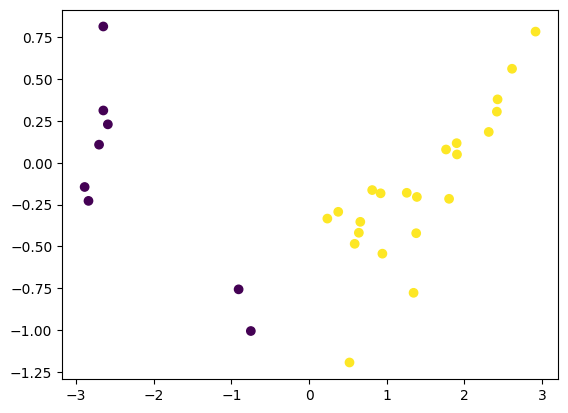

In [ ]:
y_pred = dt.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
for t in gbc.trees:
    t.print_tree()

0:-0.7045317592446643? 
 T->[0. 1.]
 F->[1. 0.]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]
0:-0.7045317592446643? 
 T->[-0.5  0.5]
 F->[ 0.5 -0.5]


Обучение: 100% [-----------------------------------------------] Time:  0:00:07


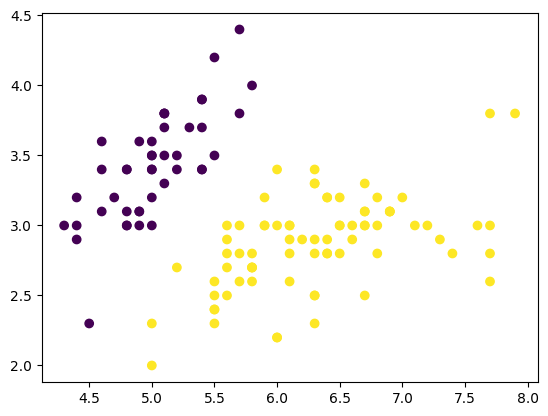

In [ ]:
X_ = iris.data
X_train, X_test, y_train, y_test = train_test_split(X_, Y, test_size=0.2, shuffle=True, seed=123)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.05, min_samples_split=10, min_info_gain=1e-7, max_depth=4, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

In [ ]:
for t in gbc.trees:
    t.print_tree()

2:3.3? 
 T->[0. 1.]
 F->[1. 0.]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]
2:3.3? 
 T->[-0.05  0.05]
 F->[ 0.05 -0.05]


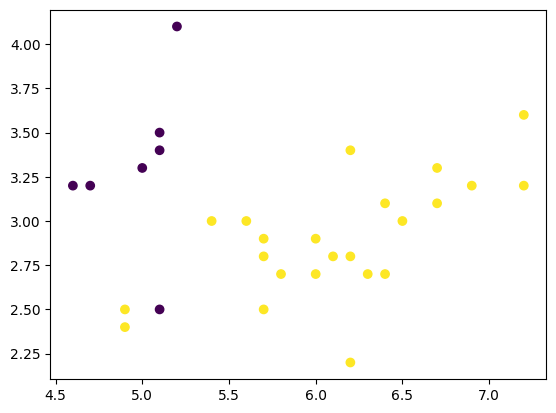

In [ ]:
y_pred = gbc.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

Реализовать классификацию градиентным бустингом для набора данных German Credit Cards UCI.csv
Реализовать регрессию градиентным бустингом для набора данных Video Games
Сравнить метрики качества и скорость обучения с ранее построенными моделями.

### German Credit Cards

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv(r'German Credit Cards UCI.csv')
df.head()

,Customer ID,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,fully paid
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,charged off
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,fully paid
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,fully paid
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,charged off


In [ ]:
X = df.drop(columns=['Loan Status', 'Customer ID'])
Y = df['Loan Status']
X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = Y.apply(lambda x: 1 if x == 'fully paid' else 0).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

In [ ]:
gbc_class = GradientBoostingClassifier(n_estimators=150, learning_rate=.05, min_samples_split=10, min_info_gain=1e-7, max_depth=4, debug=False)
gbc_class.fit(X_train, y_train)
y_pred = gbc_class.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:04:31


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_train, y_pred)
print("Precision:", precision)

recall = recall_score(y_train, y_pred)
print("Recall:", recall)

f1 = f1_score(y_train, y_pred)
print("F1 score:", f1)

Accuracy: 0.9199507389162561
Precision: 0.9222972972972973
Recall: 0.9663716814159292
F1 score: 0.9438202247191011


In [ ]:
y_pred = gbc_class.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

Accuracy: 0.7475247524752475
Precision: 0.8064516129032258
Recall: 0.8561643835616438
F1 score: 0.8305647840531561


#### target encoder

In [ ]:
!pip install category_encoders

import category_encoders as ce

In [ ]:
df = pd.read_csv(r'German Credit Cards UCI.csv')
df.head()

,Customer ID,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,fully paid
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,charged off
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,fully paid
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,fully paid
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,charged off


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 22 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Customer ID                                          1014 non-null   int64 
 1   Checking Account Status                              1014 non-null   object
 2   Loan Duration (Months)                               1014 non-null   int64 
 3   Credit History                                       1014 non-null   object
 4   Purpose                                              1014 non-null   object
 5   Loan Amount                                          1014 non-null   int64 
 6   Savings Account Balance                              1014 non-null   object
 7   Present Employment Time (Years)                      1014 non-null   object
 8   Installment Rate in Percentage of Disposable Income  1014 non-null   int64 
 9

In [ ]:
df_dropped = df.drop(columns=['Loan Status', 'Customer ID'])

In [ ]:
cat_cols = list(df_dropped.select_dtypes(include='object'))

In [ ]:
df['Loan Status'].unique()

array(['fully paid', 'charged off'], dtype=object)

In [ ]:
df['Loan Status'] = df['Loan Status'].map({'fully paid': 1, 'charged off': 0})

In [ ]:
df_encoded = ce.TargetEncoder().fit_transform(X=df_dropped[cat_cols], y=df['Loan Status'])
df_encoded.head()

,Checking Account Status,Credit History,Purpose,Savings Account Balance,Present Employment Time (Years),Personal Status and Gender,Other Debtors / Guarantors,Property,Other Credits,Home Ownership,Job Category,Telephone,Foreign Worker Status
0,0.507246,0.831081,0.780919,0.827957,0.749020,0.736462,0.700436,0.790210,0.725182,0.739310,0.703762,0.720195,0.693648
1,0.609489,0.682070,0.780919,0.641109,0.696532,0.644444,0.700436,0.790210,0.725182,0.739310,0.703762,0.688226,0.693648
2,0.885000,0.831081,0.566696,0.641109,0.778409,0.736462,0.700436,0.790210,0.725182,0.739310,0.724138,0.688226,0.693648
3,0.507246,0.682070,0.675676,0.641109,0.778409,0.736462,0.814752,0.692308,0.725182,0.600012,0.703762,0.688226,0.693648
4,0.507246,0.681840,0.620253,0.641109,0.696532,0.736462,0.700436,0.573249,0.725182,0.600012,0.703762,0.688226,0.693648


In [ ]:
df[cat_cols] = df_encoded[cat_cols]
df.head()

,Customer ID,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,1122334,0.507246,6,0.831081,0.780919,1169,0.827957,0.749020,4,0.736462,...,0.790210,67,0.725182,0.739310,2,0.703762,1,0.720195,0.693648,1
1,6156361,0.609489,48,0.682070,0.780919,5951,0.641109,0.696532,2,0.644444,...,0.790210,22,0.725182,0.739310,1,0.703762,1,0.688226,0.693648,0
2,2051359,0.885000,12,0.831081,0.566696,2096,0.641109,0.778409,2,0.736462,...,0.790210,49,0.725182,0.739310,1,0.724138,2,0.688226,0.693648,1
3,8740590,0.507246,42,0.682070,0.675676,7882,0.641109,0.778409,2,0.736462,...,0.692308,45,0.725182,0.600012,1,0.703762,2,0.688226,0.693648,1
4,3924540,0.507246,24,0.681840,0.620253,4870,0.641109,0.696532,3,0.736462,...,0.573249,53,0.725182,0.600012,2,0.703762,2,0.688226,0.693648,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Loan Status'], axis=1).to_numpy(), df['Loan Status'].to_numpy().reshape(df['Loan Status'].shape[0], 1), test_size=0.2, shuffle=True, seed=123)

In [ ]:
gbc_class = GradientBoostingClassifier(n_estimators=150, learning_rate=.05, min_samples_split=10, min_info_gain=1e-7, max_depth=4, debug=False)
gbc_class.fit(X_train, y_train)
y_pred = gbc_class.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:02:26


In [ ]:
(y_train==y_pred).sum()/y_train.shape[0]

61.44581280788177

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_train, y_pred)
print("Precision:", precision)

recall = recall_score(y_train, y_pred)
print("Recall:", recall)

f1 = f1_score(y_train, y_pred)
print("F1 score:", f1)

Accuracy: 0.3041871921182266
Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred = gbc_class.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

Accuracy: 0.27722772277227725
Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### optuna

In [ ]:
pip install optuna

   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   ----------------- ---------------------- 163.8/380.1 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 380.1/380.1 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.4 kB ? eta -:--:--
   ---------------------------------------- 233.4/233.4 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------- -------------------------------- 0.4/2.1 MB 12.9 MB/s eta 0:00:01
   ------------------ --------------------- 1.0/2.1 MB 12.3 MB/s eta 0:00:01
   -------------------------- ------------- 1.4/2.1 MB 12.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.9/2.1 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/293.6 kB ? eta -:--:--
   --------------------------------------- 293.6/293.6 kB 18.9 MB/s eta 0:00:00
   ----------

In [ ]:
df = pd.read_csv(r'German Credit Cards UCI.csv')
df.head()

,Customer ID,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,fully paid
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,charged off
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,fully paid
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,fully paid
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,charged off


In [ ]:
X = df.drop(columns=['Loan Status', 'Customer ID'])
Y = df['Loan Status']
X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = Y.apply(lambda x: 1 if x == 'fully paid' else 0).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

In [ ]:
import optuna

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    n_estimators = trial.suggest_int("n_estimators", 50, 150)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_info_gain = trial.suggest_float("min_info_gain", 1e-7, 1e-6)
    max_depth = trial.suggest_int("max_depth", 1, 5)

    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_info_gain=min_info_gain,
        max_depth=max_depth
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)
    if score >= 0.75:
        trial.study.stop()

    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print(study.best_params)

[I 2024-05-21 06:12:46,755] A new study created in memory with name: no-name-f325b41b-eedf-4940-90cf-132c79595486
Обучение: 100% [------------------------------------------------] Time: 0:01:06
C:\Users\user\AppData\Local\Temp\ipykernel_19168\2862179868.py:71: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_19168\2862179868.py:71: RuntimeWarning: invalid value encountered in divide
  y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
[I 2024-05-21 06:13:53,286] Trial 0 finished with value: 0.693069306930693 and parameters: {'learning_rate': 0.09014549312868592, 'n_estimators': 50, 'min_samples_split': 5, 'min_info_gain': 1.2223132969437075e-07, 'max_depth': 2}. Best is trial 0 with value: 0.693069306930693.
Обучение: 100% [------------------------------------------------] Time: 0:04:44
C:\Users\user\AppData\Local\Temp\ipykernel_19168\28

{'learning_rate': 0.10266228165944598, 'n_estimators': 136, 'min_samples_split': 6, 'min_info_gain': 7.809281631104799e-07, 'max_depth': 5}


In [ ]:
print(study.best_params)

{'learning_rate': 0.10266228165944598, 'n_estimators': 136, 'min_samples_split': 6, 'min_info_gain': 7.809281631104799e-07, 'max_depth': 5}


In [ ]:
gbc_class = GradientBoostingClassifier(n_estimators=136, learning_rate=0.10266228165944598, min_samples_split=6, min_info_gain=7.809281631104799e-07, max_depth=5, debug=False)
gbc_class.fit(X_train, y_train)
y_pred = gbc_class.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:04:51
C:\Users\user\AppData\Local\Temp\ipykernel_19168\2862179868.py:71: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_19168\2862179868.py:71: RuntimeWarning: invalid value encountered in divide
  y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)


In [ ]:
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_train, y_pred)
print("Precision:", precision)

recall = recall_score(y_train, y_pred)
print("Recall:", recall)

f1 = f1_score(y_train, y_pred)
print("F1 score:", f1)

Accuracy: 0.9679802955665024
Precision: 0.9703315881326352
Recall: 0.984070796460177
F1 score: 0.9771528998242531


In [ ]:
y_pred = gbc_class.predict(X_test)

C:\Users\user\AppData\Local\Temp\ipykernel_19168\2862179868.py:71: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_19168\2862179868.py:71: RuntimeWarning: invalid value encountered in divide
  y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

Accuracy: 0.7623762376237624
Precision: 0.80625
Recall: 0.8835616438356164
F1 score: 0.8431372549019608


### Video Games

In [ ]:
data = pd.read_csv('Video Games.csv', index_col='id')
#data = data.drop(columns=['publisher'])

In [ ]:
data = pd.get_dummies(data, drop_first=True)
#отделим признаки от целевой переменной
Y = data['jp_sales'].values
X = data.drop(columns=['jp_sales']).values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

In [ ]:
gbc_regr = GradientBoostingRegressor(n_estimators=10, learning_rate=.1, min_samples_split=5, max_depth=5, debug=False)
gbc_regr.fit(X_train, y_train)
y_pred = gbc_regr.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:03:56


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mse = mean_squared_error(y_train, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_train, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_train, y_pred)
print("MAPE:", mape)

MSE: 0.050098578045430844
MAE: 0.1243006184132778
MAPE: 0.09055897041843239


In [ ]:
y_pred = gbc_regr.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MSE: 0.1882634567804329
MAE: 0.1555857058521589
MAPE: 0.1009786032030739


In [ ]:
y_pred = gbc_regr.predict(X)

In [ ]:
mse = mean_squared_error(Y, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(Y, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(Y, y_pred)
print("MAPE:", mape)

MSE: 0.07771208480998856
MAE: 0.13055322748102977
MAPE: 0.0926414287321313


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    n_estimators = trial.suggest_int("n_estimators", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_depth=max_depth
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = mean_squared_error(y_test, preds)
    if score <= 0.07771208480998856:
        trial.study.stop()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print(study.best_params)

[I 2024-05-21 06:41:02,145] A new study created in memory with name: no-name-0f192a9e-ff04-4a1f-b361-734daf54bcb8
Обучение: 100% [------------------------------------------------] Time: 0:05:30
[I 2024-05-21 06:46:32,852] Trial 0 finished with value: 0.15965512144005775 and parameters: {'learning_rate': 0.19622653087715394, 'n_estimators': 17, 'min_samples_split': 9, 'max_depth': 4}. Best is trial 0 with value: 0.15965512144005775.
Обучение: 100% [------------------------------------------------] Time: 0:03:12
[I 2024-05-21 06:49:45,033] Trial 1 finished with value: 0.1694803849691995 and parameters: {'learning_rate': 0.04989161533764734, 'n_estimators': 7, 'min_samples_split': 9, 'max_depth': 6}. Best is trial 0 with value: 0.15965512144005775.
Обучение: 100% [------------------------------------------------] Time: 0:05:37
[I 2024-05-21 06:55:22,093] Trial 2 finished with value: 0.17891279210852187 and parameters: {'learning_rate': 0.06772372455896881, 'n_estimators': 18, 'min_samples

{'learning_rate': 0.11131666829114377, 'n_estimators': 14, 'min_samples_split': 9, 'max_depth': 9}


In [ ]:
print(study.best_params)

{'learning_rate': 0.11131666829114377, 'n_estimators': 14, 'min_samples_split': 9, 'max_depth': 9}


In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.15)
    n_estimators = trial.suggest_int("n_estimators", 5, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 8)
    max_depth = trial.suggest_int("max_depth", 3, 7)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_depth=max_depth
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = mean_squared_error(y_test, preds)
    if score <= 0.07771208480998856:
        trial.study.stop()

    return score

In [ ]:
study.optimize(objective, n_trials=10)

print(study.best_params)

[I 2024-05-21 07:39:10,225] A new study created in memory with name: no-name-be9f9b27-af2b-4cd8-a171-cce01bda869b
Обучение: 100% [------------------------------------------------] Time: 0:02:13
[I 2024-05-21 07:41:23,722] Trial 0 finished with value: 0.1721160539694856 and parameters: {'learning_rate': 0.1029651596000428, 'n_estimators': 5, 'min_samples_split': 4, 'max_depth': 7}. Best is trial 0 with value: 0.1721160539694856.
Обучение: 100% [------------------------------------------------] Time: 0:04:33
[I 2024-05-21 07:45:57,116] Trial 1 finished with value: 0.1788609104386552 and parameters: {'learning_rate': 0.1385809950781336, 'n_estimators': 12, 'min_samples_split': 8, 'max_depth': 5}. Best is trial 0 with value: 0.1721160539694856.
Обучение: 100% [------------------------------------------------] Time: 0:04:24
[I 2024-05-21 07:50:21,578] Trial 2 finished with value: 0.18126224753489292 and parameters: {'learning_rate': 0.13206719909162873, 'n_estimators': 14, 'min_samples_spli

{'learning_rate': 0.07275836606343852, 'n_estimators': 11, 'min_samples_split': 7, 'max_depth': 3}


In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.08, 0.12)
    n_estimators = trial.suggest_int("n_estimators", 9, 11)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 6)
    max_depth = trial.suggest_int("max_depth", 4, 6)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_depth=max_depth
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = mean_squared_error(y_test, preds)
    if score <= 0.07771208480998856:
        trial.study.stop()

    return score

In [ ]:
study.optimize(objective, n_trials=10)

print(study.best_params)

Обучение: 100% [------------------------------------------------] Time: 0:03:20
[I 2024-05-21 08:29:09,699] Trial 10 finished with value: 0.18152829617272898 and parameters: {'learning_rate': 0.08024445436344137, 'n_estimators': 11, 'min_samples_split': 5, 'max_depth': 4}. Best is trial 7 with value: 0.15857049896999276.
Обучение: 100% [------------------------------------------------] Time: 0:03:52
[I 2024-05-21 08:33:01,935] Trial 11 finished with value: 0.1895100182739905 and parameters: {'learning_rate': 0.08069920940065947, 'n_estimators': 10, 'min_samples_split': 6, 'max_depth': 5}. Best is trial 7 with value: 0.15857049896999276.
Обучение: 100% [------------------------------------------------] Time: 0:02:44
[I 2024-05-21 08:35:46,662] Trial 12 finished with value: 0.18249053819326833 and parameters: {'learning_rate': 0.08661580473689826, 'n_estimators': 9, 'min_samples_split': 6, 'max_depth': 4}. Best is trial 7 with value: 0.15857049896999276.
Обучение: 100% [-----------------

{'learning_rate': 0.07275836606343852, 'n_estimators': 11, 'min_samples_split': 7, 'max_depth': 3}


In [ ]:
print(study.best_params)

{'learning_rate': 0.07275836606343852, 'n_estimators': 11, 'min_samples_split': 7, 'max_depth': 3}


In [ ]:
gbc_regr = GradientBoostingRegressor(n_estimators=11, learning_rate=0.07275836606343852, min_samples_split=7, max_depth=3, debug=False)
gbc_regr.fit(X_train, y_train)
y_pred = gbc_regr.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:02:54


In [ ]:
mse = mean_squared_error(y_train, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_train, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_train, y_pred)
print("MAPE:", mape)

MSE: 0.07108836585663496
MAE: 0.14214269908702767
MAPE: 0.10115243065826043


In [ ]:
y_pred = gbc_regr.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MSE: 0.15857049896999276
MAE: 0.1558389548214967
MAPE: 0.10392587588400436


In [ ]:
y_pred = gbc_regr.predict(X)

In [ ]:
mse = mean_squared_error(Y, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(Y, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(Y, y_pred)
print("MAPE:", mape)

MSE: 0.08857246526468275
MAE: 0.1448800202777353
MAPE: 0.10170672889384244
